# Task

The data is the same as in the Classification 2 module. So it allows you to compare classical methods with neural network approaches.

Metrics: Define by yourself. Explain your decision

Evaluation:

*   EDA + Preprocessing - 1
*   Train linear model based on TF-IDF as a baseline - 1
*   Build and train different versions of RNN models (e.g . LSTM, Bidirectional LSTM) - 3
    *   Pretrained embedding (word2vec) - 1
    *   Early Stopping using val_loss - 1
    *   Model Checkpoints (save model) - 1
    *   Hyperparameter tuning - 1
*   Compare performance of models - 1
*   Plot confusion matrix for (y_true, y_pred) - 1
*   Plot learning curve - 1
*   WordCloud - 1
*   Detailed conclusions: 2

Quality of delivered work:
*   Analytical comments provided: 1
*   The experiment is structured (file is readable, pictures have titles): 1
Code is clear (reusable code in functions,comments,code is easy readable): 1
*   Extra points for improvements not considered in the criteria: 2

Total: 20 points.

Additional
*   Try to use different types of pretrained embeddings such as fastText, GloVe and so on.
*   Try to use GPU
*   Try BERT based approach


####**Так как в разделе Classification 2 был уже проведен анализ данного текста классическими методами, то мной было принято следующее решение:**

*   просто привести текст предыдущей работы (оставлена лишь логистическая регрессия)
*   а в новой части добавить нейронные сети, plot learning curve, а также сравнить эффективность классических методов (Logistic regression) и нейронных сетей


# Classical methods

## Preluminaries

### Imports

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_context('notebook')
%config InlineBackend.figure_format = 'retina'

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from wordcloud import WordCloud

import re

plt.rcParams['figure.figsize'] = 12, 12

import warnings 
warnings.filterwarnings('ignore')

from google_drive_downloader import GoogleDriveDownloader as gdd

### Auxiliary functions

In [ ]:
def get_hashtags(text):
    return re.findall( r'#(\w+)', text)

In [ ]:
def calculate_stats(text_series):
    stats = pd.DataFrame()
    stats['len'] = text_series.apply(lambda x: len(x))
    stats['n_numbers'] = text_series.apply(lambda x: sum(c.isdigit() for c in x))
    stats['numbers_ratio'] = stats.n_numbers / (stats.len + 1e-09)
    stats['n_words'] = text_series.apply(lambda x: len(re.findall(r'[a-zA-Z_]+', x)))
    stats['avg_word_len'] = text_series.apply(lambda x: np.mean([len(w) for w in re.findall(r'[a-zA-Z_]+', x)])) 
    stats['n_letters'] = text_series.apply(lambda x: sum(c.isalpha() for c in str(x)))
    stats['n_spaces'] = text_series.apply(lambda x: sum(c.isspace() for c in str(x)))
    stats['n_capitals'] = text_series.apply(lambda x: sum(c.isupper() for c in str(x)))
    stats['capitals_ratio'] = stats.n_capitals / (stats.n_words + 1e-09)
    return stats


### Download & Overview

In [ ]:
gdd.download_file_from_google_drive(file_id='1IFiTjjRxNkw2SXwshnHGgQc-PyXMjuic',\
                                    dest_path='/data/LargeMovieReviewDataset.csv')
df = pd.read_csv('/data/LargeMovieReviewDataset.csv', sep=',')

In [ ]:
df.sample(5)

review sentiment
41362  You could get into the nitty gritty of this fi...  positive
38373  Really, I can't believe that I spent $5 on thi...  negative
35930  Superbly trashy and wondrously unpretentious 8...  positive
42792  Deepa Mehta's "Fire" is groundbreaking, bold, ...  positive
48854  The movie is basically a boring string of appa...  negative

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [ ]:
df.shape

(50000, 2)

In [ ]:
df.sentiment

0        positive
1        positive
2        positive
3        negative
4        positive
           ...   
49995    positive
49996    negative
49997    negative
49998    negative
49999    negative
Name: sentiment, Length: 50000, dtype: object

In [ ]:
df.sentiment.value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

Все достаточно равномерно и сбалансировано. Как хорошо.

## EDA & Data preprocessing

In [ ]:
df.isna().sum()

review       0
sentiment    0
dtype: int64

Пропусков нет.

Пусть negative - 0, positive - 1.

In [ ]:
df.sentiment.replace({'negative': 0, 'positive': 1}, inplace = True)

In [ ]:
df.head(5)

review  sentiment
0  One of the other reviewers has mentioned that ...          1
1  A wonderful little production. <br /><br />The...          1
2  I thought this was a wonderful way to spend ti...          1
3  Basically there's a family where a little boy ...          0
4  Petter Mattei's "Love in the Time of Money" is...          1

In [ ]:
df.dtypes

review       object
sentiment     int64
dtype: object

In [ ]:
df.review[9]

'If you like original gut wrenching laughter you will like this movie. If you are young or old then you will love this movie, hell even my mom liked it.<br /><br />Great Camp!!!'

In [ ]:
df.review[8]

"Encouraged by the positive comments about this film on here I was looking forward to watching this film. Bad mistake. I've seen 950+ films and this is truly one of the worst of them - it's awful in almost every way: editing, pacing, storyline, 'acting,' soundtrack (the film's only song - a lame country tune - is played no less than four times). The film looks cheap and nasty and is boring in the extreme. Rarely have I been so happy to see the end credits of a film. <br /><br />The only thing that prevents me giving this a 1-score is Harvey Keitel - while this is far from his best performance he at least seems to be making a bit of an effort. One for Keitel obsessives only."

Есть сокращения, много чего нужно чистить. Проверим, есть ли хэштеги.

In [ ]:
df['hashtags'] = df.review.apply(get_hashtags)
df.head(5)

review  sentiment hashtags
0  One of the other reviewers has mentioned that ...          1       []
1  A wonderful little production. <br /><br />The...          1       []
2  I thought this was a wonderful way to spend ti...          1       []
3  Basically there's a family where a little boy ...          0       []
4  Petter Mattei's "Love in the Time of Money" is...          1       []

In [ ]:
df.hashtags.value_counts()

TypeError: ignored

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas/_libs/hashtable_class_helper.pxi", line 1709, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


[]            49760
[1]              69
[1, 2]           23
[2]              23
[3]               9
              ...  
[701, 701]        1
[88]              1
[1, 81]           1
[yawws]           1
[Western]         1
Name: hashtags, Length: 95, dtype: int64

Всего полей с хештегами 240. Это немного в сравнении с общим объемом записей. И не создаст какой-то внятной картины. Мы не будем их удалять большинство из них имеют встречаемость меньше 10. А те три, что больше, просто войдут в словарь.

Посмотрим на статистики, вдруг они нам что-то дадут.

In [ ]:
statistic = calculate_stats(df.review)
statistic.head()

len  n_numbers  numbers_ratio  ...  n_spaces  n_capitals  capitals_ratio
0  1761          1       0.000568  ...       306          43        0.134796
1   998          0       0.000000  ...       161          16        0.096386
2   926          1       0.001080  ...       165          23        0.134503
3   748          3       0.004011  ...       137          24        0.172662
4  1317          0       0.000000  ...       229          34        0.144068

[5 rows x 9 columns]

In [ ]:
df = df.iloc[:, 0:2]

In [ ]:
df

review  sentiment
0      One of the other reviewers has mentioned that ...          1
1      A wonderful little production. <br /><br />The...          1
2      I thought this was a wonderful way to spend ti...          1
3      Basically there's a family where a little boy ...          0
4      Petter Mattei's "Love in the Time of Money" is...          1
...                                                  ...        ...
49995  I thought this movie did a down right good job...          1
49996  Bad plot, bad dialogue, bad acting, idiotic di...          0
49997  I am a Catholic taught in parochial elementary...          0
49998  I'm going to have to disagree with the previou...          0
49999  No one expects the Star Trek movies to be high...          0

[50000 rows x 2 columns]

### Conclusion

В этой части просто посмотрели, а что за данные. Провели бинаризацию столбца target.

Узнали, что есть хэштеги и определились, что с ними делать. Но особо глубокой работы не проводилось.

## Data Processing - 2

### Imports

In [ ]:
!pip install spellchecker

     |████████████████████████████████| 3.9MB 5.3MB/s 
  Created wheel for spellchecker: filename=spellchecker-0.4-cp36-none-any.whl size=3966516 sha256=84e6162f7664327a5805ecca4d2bfccb46f36f27dba9a01ae97df4812974cea1
  Stored in directory: /root/.cache/pip/wheels/a2/e6/ad/28ab959cba7100f5c562a3d1711cd34b630734d241c4e1bd40
  Created wheel for inexactsearch: filename=inexactsearch-1.0.2-cp36-none-any.whl size=7113 sha256=42563c2e792a55ad5c896d87f8da0c8f38b7393a2a4fa13f7fafa1ba4cdeed0c
  Stored in directory: /root/.cache/pip/wheels/58/e0/c1/e3fed0e9fd1a3708bc91870fb0ba30ef88527540006763674b
  Created wheel for soundex: filename=soundex-1.1.3-cp36-none-any.whl size=8862 sha256=18f933ece699321970969f561d52c1d82c0859ca93dfcabc1f1442e4e2f8de5d
  Stored in directory: /root/.cache/pip/wheels/b5/bb/e6/9a4b6be56c40aa707509bddaf6d414187461ded9db7a25a41a
  Created wheel for silpa-common: filename=silpa_common-0.3-cp36-none-any.whl size=8453 sha256=10b5c14dc32901814701373e68d533b72a7bf8a5fd2015b69d

In [ ]:
!pip install unidecode

     |████████████████████████████████| 245kB 6.4MB/s 


In [ ]:
!pip install pyspellchecker

     |████████████████████████████████| 1.9MB 6.6MB/s 


In [ ]:
from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectKBest, f_classif

import nltk
nltk.download('stopwords')
nltk.download('punkt')

from bs4 import BeautifulSoup
import unidecode
import string

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
from spellchecker import SpellChecker

### Text pre-processing

List of Text Preprocessing Steps: 

1. Remove HTML tags
2. Remove URL tags
3. Remove extra whitespaces
4. Remove emojiis
5. Convert accented characters to ASCII characters
6. Lowercase all texts
7. Remove numbers
8. Spellcheck
9. Expand contractions
10. Remove punctuation
11. Remove stopwords
12. Lemmatization

Будем проводить все эти этапы следующим образом: вначале первые 7 в одну фукнцию, потом работа с сокращениями и пунктуацией будет проведена отдельно. Причины этого будут объяснены ниже.

#### Auxliary functions

In [ ]:
def strip_html_tags(text):
    """remove html tags from text"""
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text(separator=" ")
    return stripped_text

In [ ]:
def remove_URL(text):
    url = re.compile(r'http(s*)?://\S+|www\.\S+')
    return url.sub(r'',text)

In [ ]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [ ]:
def remove_accented_chars(text):
    """remove accented characters from text, e.g. café"""
    text = unidecode.unidecode(text)
    return text

In [ ]:
def correct_spellings(text):
    spell = SpellChecker()
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)

In [ ]:
def step_1_7(text):

  translate_table = dict((ord(char), None) for char in '0123456789')

  text = text.apply(lambda row: strip_html_tags(row))
  text = text.apply(lambda row: remove_URL(row))
  text = text.apply(lambda row: row.strip())
  text = text.apply(lambda row: remove_emoji(row))
  text = text.apply(lambda row: remove_accented_chars(row))
  text = text.apply(lambda row: row.lower())
  text = text.apply(lambda row: row.translate(translate_table))

  return text

In [ ]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

#### Actual cleaning

In [ ]:
df.review = step_1_7(df.review)

In [ ]:
  #df.review = df.review.apply(lambda row: correct_spellings(row))

SpellChecker работает очень-очень медленно. Приняла решение исключить его.На меньшем наборе данных все ок. Закомментила его.

In [ ]:
df

review  sentiment
0      one of the other reviewers has mentioned that ...          1
1      a wonderful little production.  the filming te...          1
2      i thought this was a wonderful way to spend ti...          1
3      basically there's a family where a little boy ...          0
4      petter mattei's "love in the time of money" is...          1
...                                                  ...        ...
49995  i thought this movie did a down right good job...          1
49996  bad plot, bad dialogue, bad acting, idiotic di...          0
49997  i am a catholic taught in parochial elementary...          0
49998  i'm going to have to disagree with the previou...          0
49999  no one expects the star trek movies to be high...          0

[50000 rows x 2 columns]

Итак, были проведены первые 7 намеченных ступеней чистки. 

Отметим, что при обработке чисел была выбрана следующая стратегия: так как работа ведется с оценкой отзывов, то было принято решение удалить все цифры - они не несут никакой информации о характере отзыва.

Также не было проведено никакой особой работы с специальными терминами. Тексты достаточно массовые, поэтому и исключать их незачем.

Следующим этапом запланирована работа с сокращениями. Заметим, что в той же Википедии список с сокращениями в английском содержит не более 100 значений, причем достаточно много архаичных, не используемых в современных реалиях. Можно предположить, что в реальности нужно очень постараться, чтобы встретить больше 200 - 300.

Конечно, можно было бы написать словарь. 

Но это не большие числа. Поэтому для данной работы было принято решение сначала использовать более простую функцию. А потом просто посмотреть количество апострофов, которые остались в живых. И понять, а что с ними делать дальше.

In [ ]:
df.review = df.review.apply(lambda row: decontracted(row))

In [ ]:
k = 0
for i in range (df.shape[0]):
    if df.review[i].find("\'") != -1:
        k += 1
        print (i, df.review[i])

1 a wonderful little production.  the filming technique is very unassuming- very old-time-bbc fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece.  the actors are extremely well chosen- michael sheen not only "has got all the polari" but he has all the voices down pat too! you can truly see the seamless editing guided by the references to williams' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. a masterful production about one of the great master is of comedy and his life.  the realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional  wouldream' techniques remains solid then disappears. it plays on our knowledge and our senses, particularly with the scenes concerning orton and halliwell and the sets (particularly of their flat with halliwell is murals decorating every surface) are terribly well done.
5 probably my all-time fav

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



at first i was weirded out that a tv show is main character could bring the dead back to life, but then i thought i would give it a shot. guess what? i love "pushing daisies" and look forward to wednesday nights just to watch it, then for the next week i watch it a few more times on my dvr. the colorful characters, witty banter, fast-paced dialogue, and new unique situations draws me in and captivates from beginning to end. ned and chuck charles' relationship is interesting to watch as they work their romance around the fact that they cannot have physical contact. even detective emerson cod is character has continued to grow in complexity. and olive snook! jiminy crispies! she cracks me up! the narrator is voice is fun to listen to and the cinematography gives me the impression that i am watching a movie instead of a tv show. i have recommended my family and friends to turn on "pushing daisies" and they are hooked too!!! the show is well worth waiting a week for a new episode and if yo

Ага - то есть, наш текст содержит еще какие-то сокращения. То есть, наша функция могла сработать неидеально. Но заметим, что найденные неидеальности - не относятся к проблеме работы функций. Это либо не сокращения, либо очень редкие сокращения. 

#### Remove punctuation

In [ ]:
import string

In [ ]:
translate_table = dict((ord(char), None) for char in string.punctuation)

df.review = df.review.apply(lambda row: row.translate(translate_table))

In [ ]:
df

review  sentiment
0      one of the other reviewers has mentioned that ...          1
1      a wonderful little production  the filming tec...          1
2      i thought this was a wonderful way to spend ti...          1
3      basically there is a family where a little boy...          0
4      petter mattei is love in the time of money is ...          1
...                                                  ...        ...
49995  i thought this movie did a down right good job...          1
49996  bad plot bad dialogue bad acting idiotic direc...          0
49997  i am a catholic taught in parochial elementary...          0
49998  i am going to have to disagree with the previo...          0
49999  no one expects the star trek movies to be high...          0

[50000 rows x 2 columns]

#### Remove stopwords


In [ ]:
stop_words = set(stopwords.words("english"))
print (stop_words)

{'than', 'during', "she's", 'after', "didn't", "mustn't", 'from', 'he', 'own', 'hers', 'under', 'mustn', 'she', 'yourself', 'most', 'being', 'were', 'all', 'doing', 'only', 'for', 'don', 'ourselves', 'because', 'above', 'down', 'm', 'there', 'or', 'be', 'itself', 'and', 'can', 'once', 'which', 'who', 'doesn', 'both', 'ma', 'below', "should've", 'its', 're', 'y', 'too', 'more', 'again', 've', 'these', 'in', 'not', 'isn', 'at', 'then', "wasn't", 'himself', 'so', 'her', 'they', 'here', 'those', "hadn't", 'up', 'was', 'to', "mightn't", 'll', 'when', 'should', "aren't", "isn't", 'yourselves', "needn't", 'that', 'hasn', "you'll", 'we', 'weren', 'now', "hasn't", 'will', 'it', 'if', 'an', 'his', 'this', 'did', 'am', "it's", "shan't", 'until', 'into', 'him', 'no', 'the', 'a', 'i', 'further', 'my', 'yours', 'shouldn', 'ours', 'against', 'few', "you'd", 'such', 'our', 'while', 'some', 'with', 'aren', "don't", 't', 'them', 'how', 'their', "you've", 'wouldn', 'over', "haven't", "shouldn't", 'do', '

In [ ]:
%%time

for i in range (df.shape[0]):
    tokens = word_tokenize(df.review[i])
    result = [i for i in tokens if not i in stop_words]
    df.review[i] = ' '.join(result)

CPU times: user 1min 17s, sys: 186 ms, total: 1min 18s
Wall time: 1min 17s


In [ ]:
del stop_words

In [ ]:
df

review  sentiment
0      one reviewers mentioned watching oz episode ho...          1
1      wonderful little production filming technique ...          1
2      thought wonderful way spend time hot summer we...          1
3      basically family little boy jake thinks zombie...          0
4      petter mattei love time money visually stunnin...          1
...                                                  ...        ...
49995  thought movie right good job creative original...          1
49996  bad plot bad dialogue bad acting idiotic direc...          0
49997  catholic taught parochial elementary schools n...          0
49998  going disagree previous comment side maltin on...          0
49999  one expects star trek movies high art fans exp...          0

[50000 rows x 2 columns]

#### Grammar

Как уже упоминалось выше, в данной работе нам настоятельно рекомендовали использовать NLTK, регулярные выражения. Поэтому на данном шаге остановим свой взор на инструментах, что нам предоставляет NLTK.

Возможно два пути: стемминг или лемматизация. 
    
Лемматизация — это процесс преобразования слова в его базовую форму. Разница между стемминг (stemming) и лемматизацией заключается в том, что лемматизация учитывает контекст и преобразует слово в его значимую базовую форму, тогда как стемминг просто удаляет последние несколько символов, что часто приводит к неверному значению и орфографическим ошибкам.

Поэтому закономерно, что на этом шаге мы остановимся на лемматизации.

In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
from nltk.stem import WordNetLemmatizer

In [ ]:
%%time

def simple_lemmatizer(text):
    lemmatizer = WordNetLemmatizer()
    text= ' '.join([lemmatizer.lemmatize(word) for word in text.split()])
    return text

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.54 µs


In [ ]:
df['review'] = df['review'].apply(simple_lemmatizer)

Обратите внимание, что есть ошибки. Потому что «are» не преобразовалось в «be», как ожидалось. Это можно исправить, если в качестве второго аргумента lemmatize() указать правильный тег «part-of-speech» (POS-тег). 

Но для больших текстов вручную это весьма затруднительно, поэтому напишем функцию для этого: найдем правильный POS-тег для каждого слова, сопоставим его с правильным входным символом, который принимает WordnetLemmatizer, и передадим его в качестве второго аргумента в lemmatize().

Для получения POS-тег будем использовать метод nltk.pos_tag().

In [ ]:
from nltk.corpus import wordnet

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [ ]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
def simple_lemmatizer(text):
    lemmatizer = WordNetLemmatizer()
    text= ' '.join([lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in text.split()])
    return text

In [ ]:
df['review'] = df['review'].apply(simple_lemmatizer)

In [ ]:
df

review  sentiment
0      one reviewer mention watch oz episode hooked r...          1
1      wonderful little production film technique una...          1
2      thought wonderful way spend time hot summer we...          1
3      basically family little boy jake think zombie ...          0
4      petter mattei love time money visually stun fi...          1
...                                                  ...        ...
49995  thought movie right good job creative original...          1
49996  bad plot bad dialogue bad act idiotic direct a...          0
49997  catholic taught parochial elementary school nu...          0
49998  go disagree previous comment side maltin one s...          0
49999  one expect star trek movie high art fan expect...          0

[50000 rows x 2 columns]

Лемматизацию можно осуществлять и с помощью други пакетов Python: Wordnet Lemmatizer, Spacy Lemmatizer, TextBlob, CLiPS Pattern, Stanford CoreNLP, Gensim Lemmatizer, TreeTagger

Хочу также отметить spaCy. Он поставляется с предварительно созданными моделями, которые могут анализировать текст и выполнять различный функционал, связанный с NLP. spaCy по умолчанию определяет часть речи и назначает соответствующую лемму. Так, он выполнил все лемматизации, которые так же выполнил лемматизатор Wordnet, с проставленным правильным тегом POS. Плюс к этому также лемматизируется такое слово как «best» превращаясь в «good».

### Conclusion

Была запланирована и в большей степени проведена работа с текстом в виде следующих шагов:

1. Remove HTML tags
2. Remove URL tags
3. Remove extra whitespaces
4. Remove emojiis
5. Convert accented characters to ASCII characters
6. Lowercase all texts
7. Remove numbers
8. Spellcheck
9. Expand contractions
10. Remove punctuation
11. Remove stopwords

Этап spellcheck был пропущен. Очень долго проводился.

Преимущественно, использовались регулярные выражения, но были случаи использования BeautifulSoup и unidecode (из любопытства).

Причины применения тех или иных методов объяснены в тексте.


## Train-test split

In [ ]:
X = pd.DataFrame(df.review)
y = pd.DataFrame(df.sentiment)

In [ ]:
#X = df.review
#y = df.sentiment

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
print ('Train set:', X_train.shape)
print ('Test set:', X_test.shape)

Train set: (35000, 1)
Test set: (15000, 1)


## Embeddings

#### CountVectorizer

Теперь используем CountVectorizer для векторизации предложений. Он берет слова каждого предложения и создает словарь всех уникальных слов в предложениях. Этот словарь можно затем использовать для создания векторного признака количества слов:

Простая и эффективная модель для размышления о текстовых документах в машинном обучении называется моделью мешка слова, или BoW.

Модель проста в том, что она отбрасывает всю информацию о порядке в словах и фокусируется на появлении слов в документе.

Нас интересуют только схемы кодирования, которые представляют, какие слова присутствуют или в какой степени они присутствуют в зашифрованных документах без какой-либо информации о порядке.

Одна из опасностей применения данного метода -  плохая масштабируемость на большой набор текстов. Есть вероятность натолкнуться на MemoryError уже при десятке тысяч документов.

In [ ]:
def statistic(df, BOW_method, topn = 10):
    
    counter = BOW_method
    counter.fit(df.review)

    print('size of vocabulary is: {}'.format(len(counter.vocabulary_)))
    bag_of_words = counter.transform(df.review)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in counter.vocabulary_.items()]
    words_freq_sorted = sorted(words_freq, key = lambda x: x[1], reverse=True)

    print('most_common_words are:')
    display(words_freq_sorted[:topn])
    return counter

Посмотрим, какие слова наиоболее часто встречаются в корпусе.

In [ ]:
statistic(df, CountVectorizer())

size of vocabulary is: 139756
most_common_words are:


[('movie', 100920),
 ('film', 93945),
 ('one', 53811),
 ('make', 44189),
 ('like', 43181),
 ('see', 41130),
 ('get', 35031),
 ('would', 30995),
 ('well', 30487),
 ('time', 30297)]

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

Интересно, как этот набор меняется в зависимости от положительности или отрицательности отзыва.

Вот статистика для положительных:

In [ ]:
statistic(df[df.sentiment == 1], CountVectorizer())

size of vocabulary is: 91673
most_common_words are:


[('film', 49912),
 ('movie', 43922),
 ('one', 27536),
 ('see', 21552),
 ('make', 20274),
 ('like', 19569),
 ('well', 16065),
 ('get', 15857),
 ('time', 15670),
 ('good', 14642)]

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

Для отрицательных:

In [ ]:
statistic(df[df.sentiment == 0], CountVectorizer())

size of vocabulary is: 88787
most_common_words are:


[('movie', 56998),
 ('film', 44033),
 ('one', 26275),
 ('make', 23915),
 ('like', 23612),
 ('bad', 21653),
 ('see', 19578),
 ('get', 19174),
 ('would', 17889),
 ('even', 15280)]

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

#### TfidfVectorizer

С практической точки зрения, более продуктивным является использование TfidfVectorizer(). Мы можем уменьшить важность токенов, которые очень часто встречаются в нашем корпусе, так как они, предположительно, менее информативны, чем некоторые фичи, которые встречаются реже. Например, "movie" и "film" несмотря на свою частоту, вероятно, несут мало смысла. Посмотрим на аналогичную статистику и для них.

In [ ]:
statistic(df, TfidfVectorizer())

size of vocabulary is: 139756
most_common_words are:


[('movie', 2658.479363700425),
 ('film', 2220.804487252618),
 ('one', 1314.4231342690907),
 ('see', 1203.4738222783674),
 ('like', 1188.1079693882812),
 ('make', 1175.2988912573464),
 ('bad', 1034.6961738690588),
 ('watch', 1014.1649046246359),
 ('get', 1006.9049911306876),
 ('good', 985.4234093395517)]

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [ ]:
statistic(df[df.sentiment == 1], TfidfVectorizer())

size of vocabulary is: 91673
most_common_words are:


[('movie', 1243.597849641192),
 ('film', 1158.4603246299753),
 ('one', 661.2217736824102),
 ('see', 626.1412173962872),
 ('like', 566.1110893988176),
 ('make', 543.0830533449778),
 ('great', 508.5957874841157),
 ('good', 504.385913029495),
 ('well', 491.30758459885544),
 ('watch', 486.15827648255754)]

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [ ]:
statistic(df[df.sentiment == 0], TfidfVectorizer())

size of vocabulary is: 88787
most_common_words are:


[('movie', 1442.771907038842),
 ('film', 1095.200109611793),
 ('bad', 721.2395207765171),
 ('one', 673.0718076608423),
 ('make', 646.4190585922219),
 ('like', 635.4862986744345),
 ('see', 595.4272148237328),
 ('get', 547.6040354604552),
 ('would', 544.2150823276476),
 ('watch', 541.5260242957228)]

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

Вообще, все очень ожидаемо. 
Применим его к нашим данным.

Причем придется обрезать наш словарь до 30 тысяч, отобрав лучшие с помощью SelectBest. У меня вылетает ОЗУ в противном случае (удаление неиспользуемых переменных не помогает)

In [ ]:
%%time

def tfidf_vectorizing(texts_train, labels_train, texts_test, labels_test):

    tfidf_vectorizer = TfidfVectorizer(analyzer='word', 
                                       decode_error = 'replace', 
                                       ngram_range = (1, 2), 
                                       max_df = 0.95, 
                                       min_df = 5, 
                                       use_idf=True)
    
    transformed_texts_train = tfidf_vectorizer.fit_transform(texts_train)
    feature_names = np.array(tfidf_vectorizer.get_feature_names())
    transformed_texts_test = tfidf_vectorizer.transform(texts_test)
    
    # Feature best selection

    selection = SelectKBest(f_classif, 
                            k=min(30000, 
                            transformed_texts_train.shape[1]))
    selection.fit(transformed_texts_train, labels_train)
    transformed_texts_train = selection.transform(transformed_texts_train).astype('float32') 
    transformed_texts_test = selection.transform(transformed_texts_test).astype('float32') 
    feature_names = feature_names[selection.get_support()]
  
    return transformed_texts_train, transformed_texts_test, feature_names

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 5.96 µs


In [ ]:
X_train_tfidf, X_test_tfidf, feature_names_tfidf = tfidf_vectorizing(X_train.review, y_train, X_test.review, y_test)

In [ ]:
print ('Train_tfidf set:', X_train_tfidf.shape)
print ('Test_tfidf set:', X_test_tfidf.shape)

Train_tfidf set: (35000, 30000)
Test_tfidf set: (15000, 30000)


## Models

### Auxiliary functions

Model_new будет проводить поиск наилучших параметров и выведение roc_auc_score

In [ ]:
def model_new(model, parameters, X_train, X_test):
    my_pipeline = Pipeline([
      ('clf', model)
    ])

    grid_search = GridSearchCV(my_pipeline, param_grid=parameters,
                           cv=StratifiedKFold(3), scoring='roc_auc', verbose=2)

    grid_search.fit(X_train, y_train)

    y_pred = grid_search.predict(X_test)

    model_score = roc_auc_score(y_test,y_pred)
    best_parameters = grid_search.best_params_

    print ('best parameters:', best_parameters)
    print("model score :",model_score)

In [ ]:
def normalized_confusion_matrix (y, predictions):
    conf = confusion_matrix(y, predictions, normalize = 'true')
    sns.heatmap(conf,
                annot=conf/np.sum(conf,axis=1), #normalized by true class sizes
                yticklabels=['Pred. Pos', 'Pred. Neg.'],
                xticklabels=['True Positive', 'True Negative'],  
                cmap= 'Blues');
    plt.title('Logistic regression confusion matrix');
    plt.xlabel('Predicted label');
    plt.ylabel('True label');

Feature Importance будет проведена в каждом из методов. Причем результаты будут представлены в виде world cloud.

In [ ]:
def feature_importance(est, features):

          importance_positive = pd.DataFrame()
          importance_positive['feature'] = features
          importance_positive['positive'] = est
          importance_positive = importance_positive.sort_values('positive', ascending=False)

          kf = pd.DataFrame(data={
                  'f_pos': list(importance_positive.feature)[:40],
                  'mean_pos': list(importance_positive.positive)[:40],
                  'f_neg': list(importance_positive.feature)[-40:],
                  'mean_neg': list(importance_positive.positive)[-40:]
                  })

          positive_string = ' '.join([word for word in kf['f_pos'].values])
          negative_string = ' '.join([word for word in kf['f_neg'].values])

          wordcloud_pos = WordCloud( 
                      background_color='salmon', 
                      colormap='Pastel1').generate(positive_string)

          wordcloud_neg = WordCloud( 
                      background_color='salmon', 
                      colormap='Pastel1').generate(negative_string)

          print ('Feature Importance')
          print(' ')
          print ('Positive features')

          plt.figure(figsize=(15, 15))
          plt.imshow(wordcloud_pos, interpolation='bilinear')
          plt.axis("off")
          plt.show()
          
          print(' ')
          print ('Negative features')

          plt.figure(figsize=(15, 15))
          plt.imshow(wordcloud_neg, interpolation='bilinear')
          plt.axis("off")
          plt.show()

### LogisticRegression & TfIdf

In [ ]:
parameters = {'clf__C': [0.05, 0.1, 1, 5, 10, 15, 30]}

In [ ]:
model_new(LogisticRegression(), parameters, X_train_tfidf, X_test_tfidf)

Fitting 3 folds for each of 7 candidates, totalling 21 fits
[CV] clf__C=0.05 .....................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ...................................... clf__C=0.05, total=   0.6s
[CV] clf__C=0.05 .....................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] ...................................... clf__C=0.05, total=   0.5s
[CV] clf__C=0.05 .....................................................
[CV] ...................................... clf__C=0.05, total=   0.5s
[CV] clf__C=0.1 ......................................................
[CV] ....................................... clf__C=0.1, total=   0.5s
[CV] clf__C=0.1 ......................................................
[CV] ....................................... clf__C=0.1, total=   0.5s
[CV] clf__C=0.1 ......................................................
[CV] ....................................... clf__C=0.1, total=   0.5s
[CV] clf__C=1 ........................................................
[CV] ......................................... clf__C=1, total=   2.1s
[CV] clf__C=1 ........................................................
[CV] ......................................... clf__C=1, total=   0.9s
[CV] clf__C=1 ........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:   33.7s finished


best parameters: {'clf__C': 30}
model score : 0.9019713780495204


In [ ]:
%%time
logreg = LogisticRegression(C = 30)
logreg_clf = logreg.fit(X_train_tfidf,y_train)
logreg_pred = logreg.predict(X_test_tfidf)

logreg_score = roc_auc_score(y_test,logreg_pred)
print("logreg score :",logreg_score)

logreg score : 0.9019713780495204
CPU times: user 4.71 s, sys: 8.28 s, total: 13 s
Wall time: 3.28 s


In [ ]:
print('Test data')
print(classification_report(y_test, logreg_pred))

Test data
              precision    recall  f1-score   support

           0       0.91      0.89      0.90      7411
           1       0.90      0.91      0.90      7589

    accuracy                           0.90     15000
   macro avg       0.90      0.90      0.90     15000
weighted avg       0.90      0.90      0.90     15000



Очень неплохой результат.

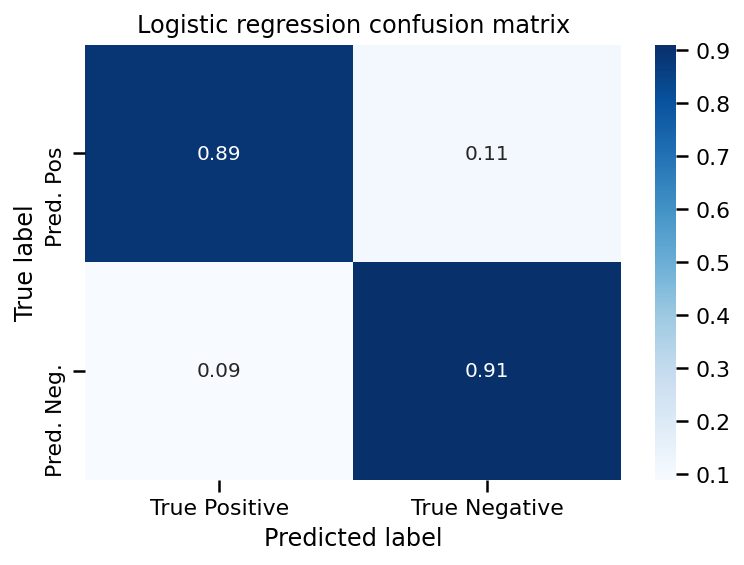

In [ ]:
normalized_confusion_matrix (y_test, logreg_pred)

Feature Importance
 
Positive features


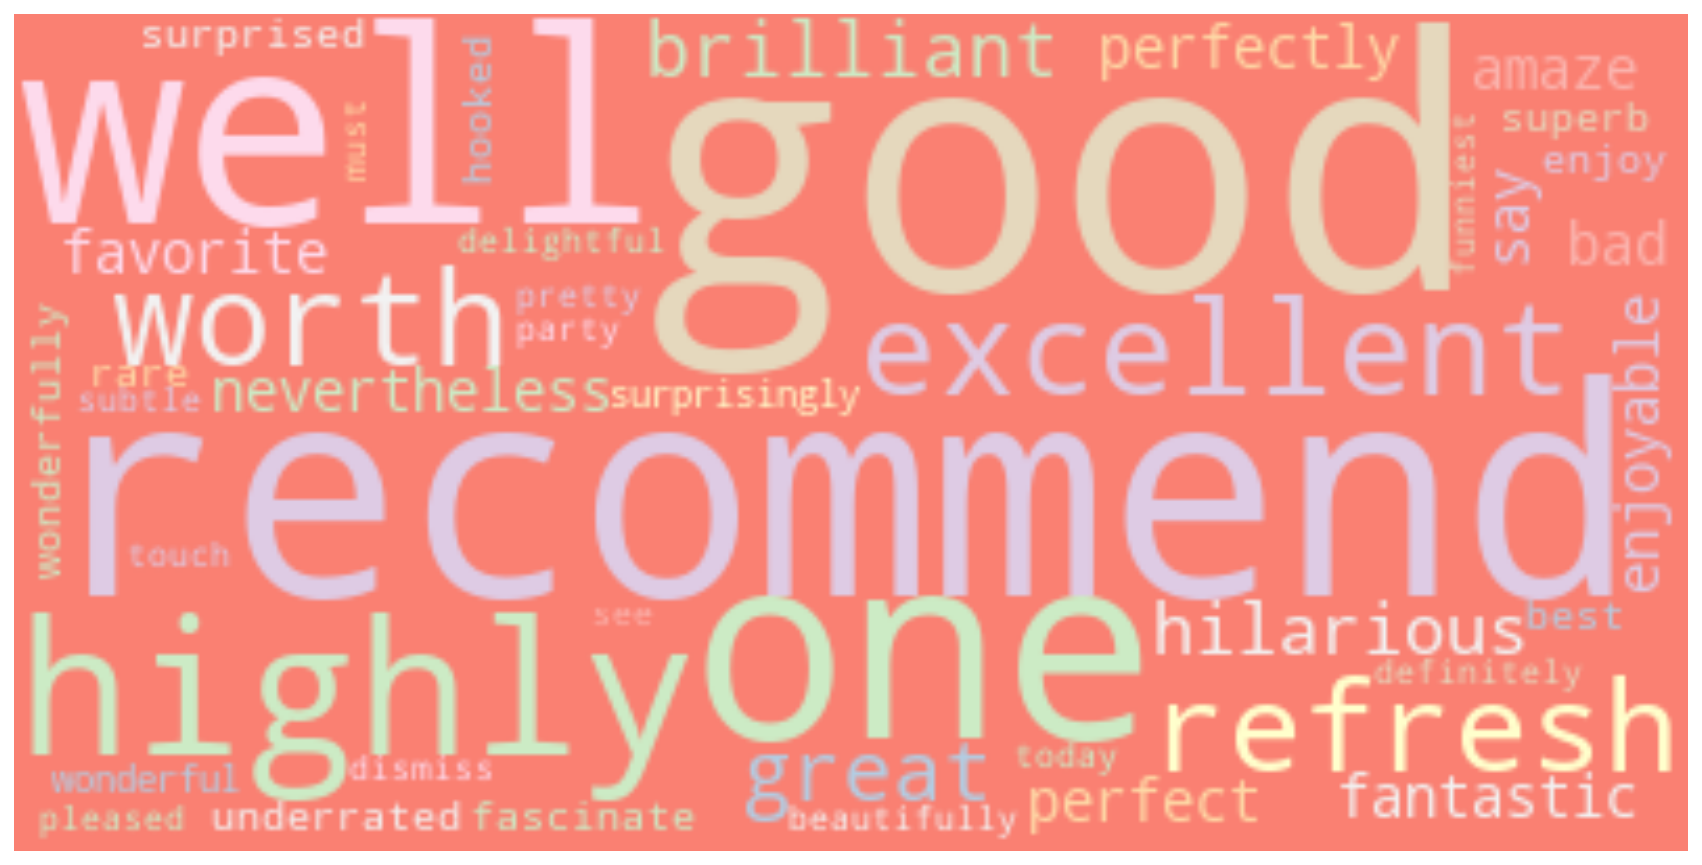

 
Negative features


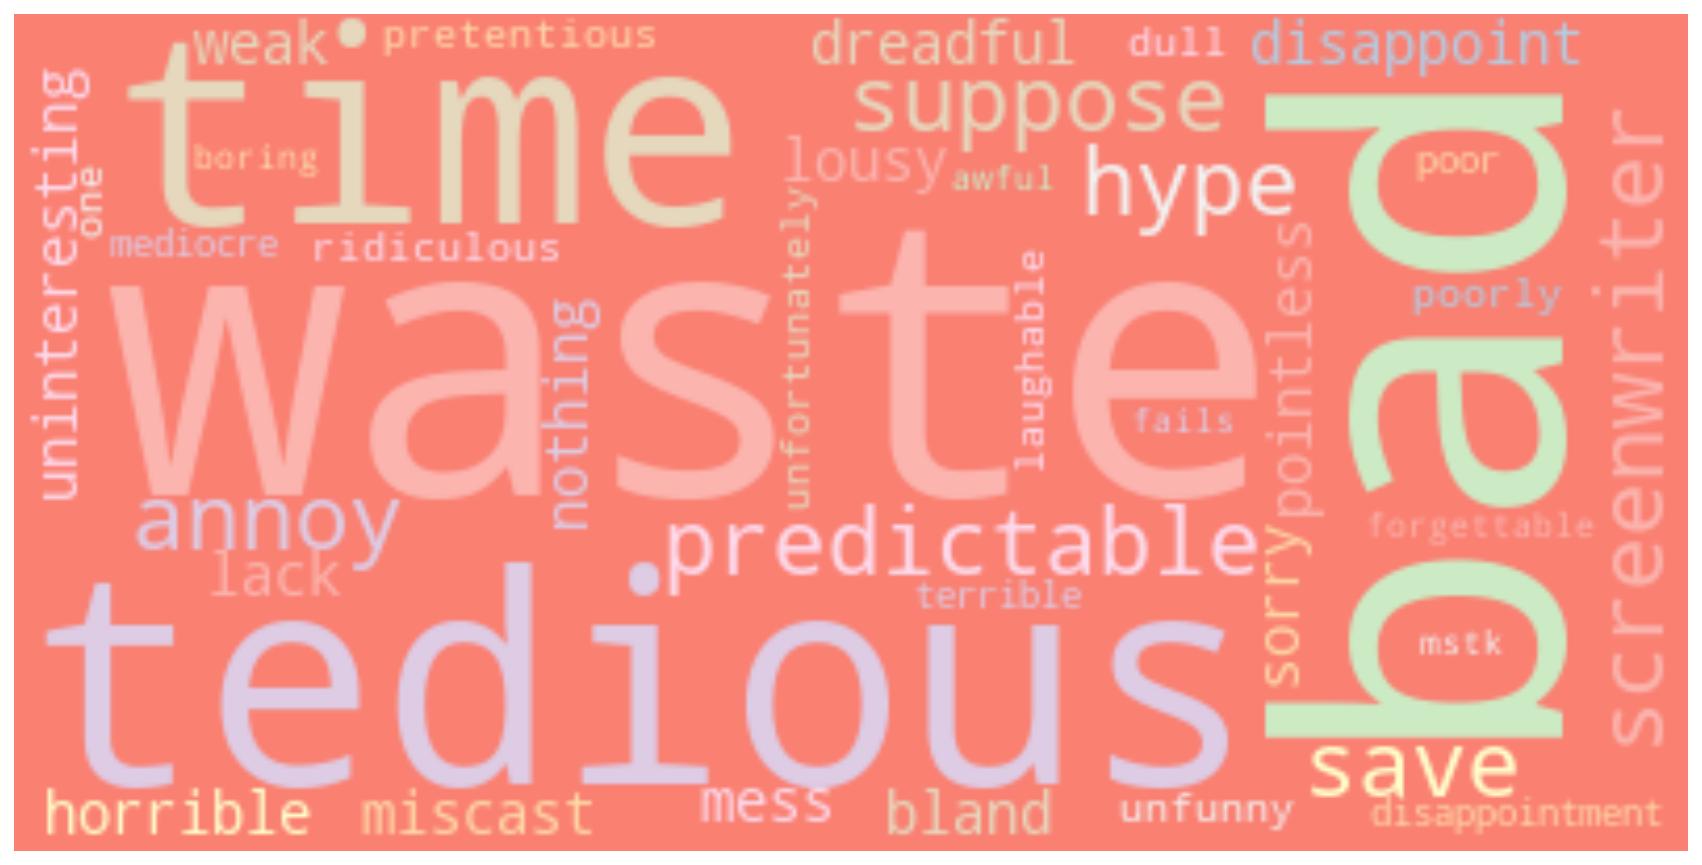

In [ ]:
feature_importance(logreg_clf.coef_[0], feature_names_tfidf)

В принципе, все: и топ позитивных и негативных - найдены весьма точно. 

# Neural networks & NLP

## Imports

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_context('notebook')
%config InlineBackend.figure_format = 'retina'

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

import spacy
import re
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from gensim.models import Word2Vec

from tensorflow import keras
from keras import layers
from keras import optimizers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.callbacks import ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, Dropout, Embedding, Flatten, LSTM, Bidirectional
from keras.models import Model
from keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from keras.models import Sequential


plt.rcParams['figure.figsize'] = 12, 12

import warnings 
warnings.filterwarnings('ignore')

from google_drive_downloader import GoogleDriveDownloader as gdd

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## EDA & Data Preporations

In [ ]:
gdd.download_file_from_google_drive(file_id='1IFiTjjRxNkw2SXwshnHGgQc-PyXMjuic',\
                                    dest_path='/data/LargeMovieReviewDataset.csv')
df = pd.read_csv('/data/LargeMovieReviewDataset.csv', sep=',')

In [ ]:
df.sample(5)

review sentiment
36537  Kubrick again puts on display his stunning abi...  positive
10712  This was just an awful movie. I've watched it ...  negative
30901  I had no idea what the film is about before I ...  negative
46648  Warning: This may contain SPOILERS!!<br /><br ...  negative
47817  I was excited when I heard they were finally m...  negative

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [ ]:
df.shape

(50000, 2)

In [ ]:
df.sentiment

0        positive
1        positive
2        positive
3        negative
4        positive
           ...   
49995    positive
49996    negative
49997    negative
49998    negative
49999    negative
Name: sentiment, Length: 50000, dtype: object

In [ ]:
df.sentiment.value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

Все достаточно равномерно и сбалансировано. Как хорошо.

In [ ]:
df[df.duplicated()]

review sentiment
3537   Quite what the producers of this appalling ada...  negative
3769   My favourite police series of all time turns t...  positive
4391   Beautiful film, pure Cassavetes style. Gena Ro...  positive
6352   If you liked the Grinch movie... go watch that...  negative
6479   I want very much to believe that the above quo...  negative
...                                                  ...       ...
49912  This is an incredible piece of drama and power...  positive
49950  This was a very brief episode that appeared in...  negative
49984  Hello it is I Derrick Cannon and I welcome you...  negative
49986  This movie is a disgrace to the Major League F...  negative
49991  Les Visiteurs, the first movie about the medie...  negative

[418 rows x 2 columns]

А вот дубликаты есть. Но их количество незначительно в сравнении с общим количеством записей, поэтому удалим их.

In [ ]:
df = df.drop_duplicates()

## Data Preporations - 2

### Auxilliary functions

In [ ]:
def remove_html(text):

    return BeautifulSoup(text).text

In [ ]:
def tokenization(text):

    tokenized_text = []
    for sent in text:      
        if sent:
            sent = sent.lower()
            sent = re.sub(r'\d+', '', sent)
            sent = re.sub('[^A-z]',' ', sent)
            tokens = word_tokenize(sent)
            
            tokens = [token for token in tokens]
            tokens = [token for token in tokens if ((len(token) > 2) 
                      and (token not in stop_words))]
            tokenized_text.append(tokens)

    return tokenized_text

In [ ]:
def to_string(text, sep):

    text = [' '.join(sent) for sent in text]
    
    return sep.join(text)

In [ ]:
def lemmatisation(text, lemmatizer, stop_words):
    
    lemmatised_text = []
    for sent in text:
        doc = lemmatizer(' '.join(sent))
        lemmatised_text.append([token.lemma_ for token in doc if token.lemma_ not in stop_words])
        
    return lemmatised_text

### Actual cleaning

Данный этап будет описан весьма кратко (более полное описание, что мы делаем и почему можно увидеть в предыдущей работе).

Мы проведем:
*   чистку
*   токенизацию, 
*   лемматизацию, используя spacy

Посмотрим, что же представляет из себя запись в review.

In [ ]:
df.review[0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

В тексте есть знаки html. Избавимся от них.

In [ ]:
df['review'] = df['review'].apply(remove_html)

In [ ]:
df['review'] = df['review'].apply(lambda x: x.split('.'))

In [ ]:
stop_words = stopwords.words('english').copy().append('-PRON-')

In [ ]:
df['tokenized'] = data['review'].apply(tokenization)

Лемматизация — это процесс преобразования слова в его базовую форму. Разница между стемминг (stemming) и лемматизацией заключается в том, что лемматизация учитывает контекст и преобразует слово в его значимую базовую форму, тогда как стемминг просто удаляет последние несколько символов, что часто приводит к неверному значению и орфографическим ошибкам.

Поэтому закономерно, что на этом шаге мы остановимся на лемматизации.

In [ ]:
%%time

df['lemmatized'] = df['tokenized'].apply(lemmatisation,  lemmatizer=spacy.load('en'), stop_words=stop_words)

### Word2vec

Word2vec — эффективный метод векторизации. Схожие слова имеют схожие координаты, находятся рядом.

In [ ]:
all_in_one = []

In [ ]:
for review in df['lemmatized'].to_list():
    for sentence in review:
        all_in_one.append(sentence)

In [ ]:
%%time

w2v = Word2Vec(all_in_one, 
                 size=32,     
                 min_count=5,  
                 window=5, ).wv 

In [ ]:
print ('Всего слов в корпусе:', len(set(' '.join(df['lemmatized'].apply(to_string, sep=' ')).split())))

In [ ]:
df['lemma_str'] = df['lemmatized'].apply(to_string, sep='. ')

Возьмем на вскидку 40000 слов, а все отзывы длиной больше 400 обрежем.

In [ ]:
words_max = 40000

In [ ]:
tokenizer = Tokenizer(words_max)
tokenizer.fit_on_texts(df['lemma_str'].values)
post_seq = tokenizer.texts_to_sequences(df['lemma_str'].values)
padded_seq = pad_sequences(post_seq, maxlen=400)

## Train-test split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(padded_seq, 
                                                    LabelEncoder().fit_transform(df['sentiment']), 
                                                    test_size=0.2, 
                                                    random_state=42)

In [ ]:
print ('Train set:', X_train.shape)
print ('Test set:', X_test.shape)

Train set: (39664, 400)
Test set: (9917, 400)


## Models

### Auxiliary functions

In [ ]:
def normalized_confusion_matrix (y, predictions):
    conf = confusion_matrix(y, predictions, normalize = 'true')
    sns.heatmap(conf,
                annot=conf/np.sum(conf,axis=1), #normalized by true class sizes
                yticklabels=['Pred. Pos', 'Pred. Neg.'],
                xticklabels=['True Positive', 'True Negative'],  
                cmap= 'Blues');
    plt.xlabel('Predicted label');
    plt.ylabel('True label');

In [ ]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(hist['epoch'], hist['acc'],
           label='Train accuracy')
    plt.plot(hist['epoch'], hist['val_acc'],
           label = 'Val accuracy')
    plt.ylim([0,1.1])
    plt.title('Model accuracy')
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Model loss')
    plt.plot(hist['epoch'], hist['loss'],
           label='Train loss')
    plt.plot(hist['epoch'], hist['val_loss'],
           label = 'Val loss')
    plt.ylim([0,1])
    plt.title('Model loss')
    plt.legend()
    plt.show()

### LSTM

In [ ]:
model_lstm = Sequential([
        layers.Embedding(words_max, 400, input_length=400),
        layers.LSTM(64),
        layers.Dropout(0.3),
        layers.Dense(2, activation='softmax')
        ])

In [ ]:
model_lstm.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [ ]:
model_lstm.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 400, 400)          16000000  
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                119040    
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 130       
Total params: 16,119,170
Trainable params: 16,119,170
Non-trainable params: 0
_________________________________________________________________


In [ ]:
EPOCHS = 10

checkpoints = ModelCheckpoint('weights-simple.hdf5', monitor='val_acc', verbose=0, save_best_only=True, mode='max')

In [ ]:
history = model_lstm.fit([X_train], 
                    y=to_categorical(y_train), 
                    verbose=1, 
                    batch_size=64, 
                    validation_split=0.2, 
                    shuffle=True, 
                    epochs=EPOCHS, 
                    callbacks=[checkpoints])

Epoch 1/10
558/558 [==============================] - 59s 106ms/step - loss: 0.3395 - acc: 0.8548 - val_loss: 0.3141 - val_acc: 0.8718
Epoch 2/10
558/558 [==============================] - 59s 106ms/step - loss: 0.1727 - acc: 0.9366 - val_loss: 0.3014 - val_acc: 0.8766
Epoch 3/10
558/558 [==============================] - 59s 105ms/step - loss: 0.1060 - acc: 0.9623 - val_loss: 0.3758 - val_acc: 0.8732
Epoch 4/10
558/558 [==============================] - 57s 102ms/step - loss: 0.0648 - acc: 0.9781 - val_loss: 0.4686 - val_acc: 0.8697
Epoch 5/10
558/558 [==============================] - 57s 103ms/step - loss: 0.0467 - acc: 0.9848 - val_loss: 0.5261 - val_acc: 0.8692
Epoch 6/10
558/558 [==============================] - 57s 103ms/step - loss: 0.0312 - acc: 0.9904 - val_loss: 0.6246 - val_acc: 0.8671
Epoch 7/10
558/558 [==============================] - 57s 102ms/step - loss: 0.0236 - acc: 0.9924 - val_loss: 0.6349 - val_acc: 0.8634
Epoch 8/10
558/558 [==============================] - 5

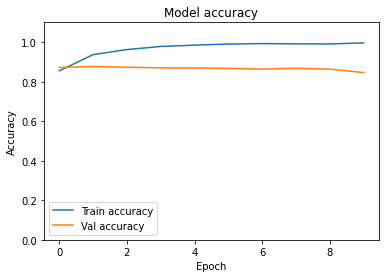

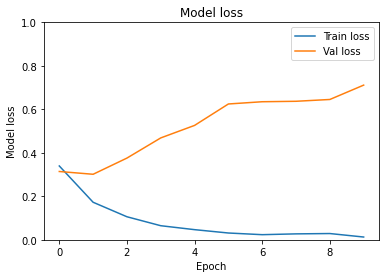

In [ ]:
plot_history(model_lstm.history)

Не очень хорошая картина в loss. По факту, модель стоит доработать.

In [ ]:
hist = pd.DataFrame(history.history)
hist.head()

loss       acc  val_loss   val_acc
0  0.339537  0.854806  0.314128  0.871821
1  0.172658  0.936577  0.301353  0.876639
2  0.105972  0.962322  0.375807  0.873165
3  0.064787  0.978093  0.468567  0.869692
4  0.046663  0.984817  0.526082  0.869244

In [ ]:
y_pred = model_lstm.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.85      0.85      2487
           1       0.85      0.83      0.84      2472

    accuracy                           0.84      4959
   macro avg       0.84      0.84      0.84      4959
weighted avg       0.84      0.84      0.84      4959



Для наглядности построим confusion_matrix

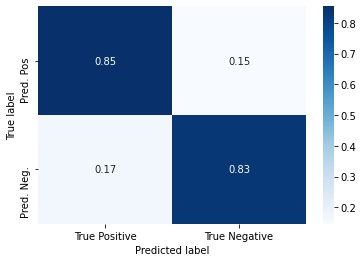

In [ ]:
normalized_confusion_matrix (y_test, y_pred)

Заметим, что скоры ниже в сравнении с результатами Logistic regression. Причем по всем аспектам.

###  Bidirectional LSTM

Сделаем все тоже самое. Но вместо LSTM возьмем 
Bidirectional LSTM.

In [ ]:
model_bi = Sequential([
        layers.Embedding(words_max, 400, input_length=400),
        layers.Bidirectional(LSTM(64)),
        layers.Dropout(0.3),
        layers.Dense(2, activation='softmax')
        ])

In [ ]:
model_bi.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [ ]:
model_bi.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 400, 400)          16000000  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               238080    
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 258       
Total params: 16,238,338
Trainable params: 16,238,338
Non-trainable params: 0
_________________________________________________________________


Установим параметр early stopping.

In [ ]:
EPOCHS = 10

early_stop = keras.callbacks.EarlyStopping(monitor='val_acc', patience=5)

In [ ]:
history = model_bi.fit([X_train], 
                    y=to_categorical(y_train), 
                    batch_size=64,
                    verbose=1, 
                    validation_split=0.2, 
                    shuffle=True, 
                    epochs=EPOCHS, 
                    callbacks=[early_stop])

Epoch 1/10
558/558 [==============================] - 68s 121ms/step - loss: 0.3494 - acc: 0.8493 - val_loss: 0.2802 - val_acc: 0.8854
Epoch 2/10
558/558 [==============================] - 67s 119ms/step - loss: 0.1721 - acc: 0.9372 - val_loss: 0.3140 - val_acc: 0.8687
Epoch 3/10
558/558 [==============================] - 67s 121ms/step - loss: 0.1003 - acc: 0.9641 - val_loss: 0.3995 - val_acc: 0.8737
Epoch 4/10
558/558 [==============================] - 67s 120ms/step - loss: 0.0620 - acc: 0.9789 - val_loss: 0.5630 - val_acc: 0.8662
Epoch 5/10
558/558 [==============================] - 67s 120ms/step - loss: 0.0490 - acc: 0.9841 - val_loss: 0.5334 - val_acc: 0.8687
Epoch 6/10
558/558 [==============================] - 67s 120ms/step - loss: 0.0450 - acc: 0.9854 - val_loss: 0.5090 - val_acc: 0.8603


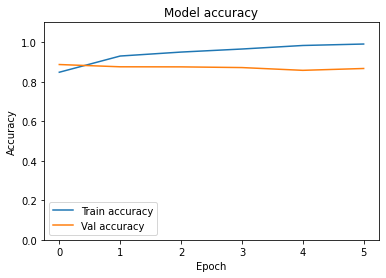

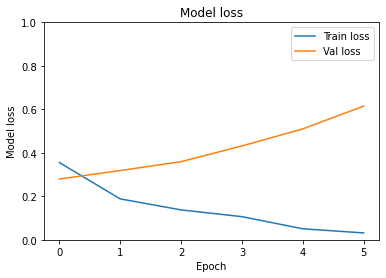

In [ ]:
plot_history(model_bi.history)

С loss вновь не очень

In [ ]:
hist = pd.DataFrame(history.history)
hist.head()

loss       acc  val_loss   val_acc
0  0.349438  0.849315  0.280225  0.885378
1  0.172080  0.937222  0.313956  0.868683
2  0.100302  0.964087  0.399482  0.873725
3  0.062001  0.978934  0.563033  0.866219
4  0.049005  0.984144  0.533377  0.868683

In [ ]:
y_pred = model_bi.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.82      0.85      2487
           1       0.83      0.89      0.86      2472

    accuracy                           0.86      4959
   macro avg       0.86      0.86      0.86      4959
weighted avg       0.86      0.86      0.86      4959



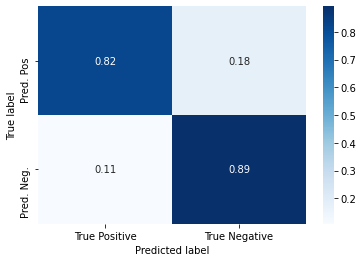

In [ ]:
normalized_confusion_matrix (y_test, y_pred)

Результаты лишь незначительно лучше, чем в предыдущей модели. Но хуже, чем в логистической регрессии.

## Conclusion

Что же получилось в результате? 

Классический метод логистическая регрессия сработал значительно лучше, чем нейронки (правда примененные достаточно топорно).

Полученные результаты наводят на интересные выводы: при необходимости получения быстрых результатов или  не сложной структуры данных применение классических методов может оказаться результативней, чем использование чего-то сложного.

В общем, все в соответвии с принципом бритвы Оккама: **«Не следует множить сущее без необходимости»**